In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,sys
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *


Could not import libcpab, error was
No module named 'libcpab'


In [3]:
import argparse; import sys; sys.argv=['']; del sys

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp,mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=1, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-4, help='learning rate for adam optimizer') # 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/orig_3aa.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_target', type=str, default="../data/ref_3aa3g.aln", help='Reference sequence as my desired output') #ref_3aa3g.aln
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    gpsetup.add_argument('--Task', type=int, default = 5, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=float, default = 0.25, help='multitaks-gp initialization')
    gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.0, 0.33, 0.33, 0.33], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [0,0.0004], help='noise constrain') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=40, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=40, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=5, help='dimensionality of the latent space') #5
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_MSA_test = std.parserinfo('path_target')#PathMSAref4t
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])
print('Ok')


None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
fill_criteria = 'token,token_target' #'token,gap'
length_filling = 0

 # Reference Information - how the alignment should looks like
alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_MSA_test, alphabet = ['-','.', 'L', 'Q', 'R'])
# Raw Sequences, to see if we can align the sequences somehow
dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)

x1 = dataset_msa.prot_space
#padded_idx, non_padded_idx, x1, ref_msa, outsize = padding_pattern_input_target(x1, ref_msa, type_of_fill, c2i)


fill_inp , fill_target = fill_criteria.split(',')
x1, ref_msa, outsize = experiment_utilities.padding_strategy_input_target(x1.float(), ref_msa.float(), fill_inp, fill_target, c2i, after_bound = length_filling)
dataset_msa.prot_space = x1

tmp


In [6]:
# Logdir for results
if args.logdir == '':
    logdir = 'res/' + args.model + '/' + datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
else:
    logdir = 'res/' + args.model + '/' + args.logdir

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
seq_size = ( [*dataset_msa.prot_space.shape][1:])
#seq_size = (dataset_msa.prot_space.shape[1],dataset_msa.prot_space.shape[1]) 


# Construct model
model_class = get_model(args.model)
model = model_class(input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_list_encoders(args.ed_type.split(",")[0:2]), 
                    decoder = get_list_decoders(args.ed_type.split(",")[2:4]),  
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ) )
                    #alphabet_size = len(dataset_msa.c2i) )

# Summary of model
#model_summary(model)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr) #, weight_decay=1e-6) #lr=1e-3 and weigh_dacay1e-6 - 1e-7 in that range is working for such examples
model_name = '/trained_model_softmax.pt'

if os.path.isfile(logdir + model_name):
    print ("Loading Deformation Model")
    model.load_state_dict(torch.load(logdir + model_name))
    testloader, _ = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=448)
    #testloader = next(iter(testloader))[0].to(torch.float32).to('cpu')
else:
    # Train model
    Trainer = vae_trainer(seq_size, model, optimizer)
    Trainer.fit2(trainloader=trainloader, 
                n_epochs=args.n_epochs, 
                warmup=args.warmup, 
                logdir=logdir,
                testloader=None,#testloader,
                eq_samples=args.eq_samples, 
                iw_samples=args.iw_samples,
                beta=args.beta,
                eval_epoch=args.eval_epoch,
                ref = ref_msa,
                requires_grad=True)
    

    # Save model
    #torch.save(model.state_dict(), logdir + model_name)

model.eval()
recon_data_train = model(dataset_msa.prot_space, 1, 1, 1.)



xmean = recon_data_train[0].squeeze(1)
cpab1 = model.x_trans1

#cpabZ2 = model.xmean_before_reverse


print('Done')




Loading data
Number of training points:  1


Epoch 1/500:   0%|          | 0/1 [00:00<?, ?samples/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Epoch 136/500:   0%|          | 0/1 [00:00<?, ?samples/s]/opt/conda/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1635: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(11,11) is zero, singular U.. Using symeig method.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding

Total train time 95.78608703613281
Saving embeddings, maybe?
Did not save embeddings for training set
list index out of range
Done


torch.Size([1, 6, 5])


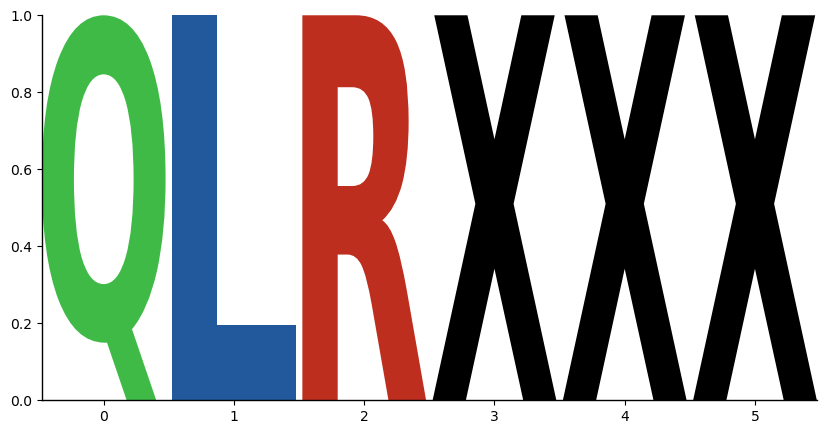

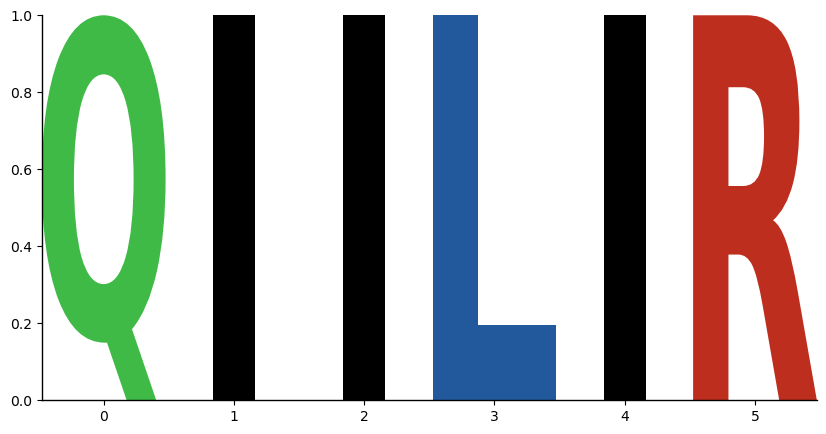

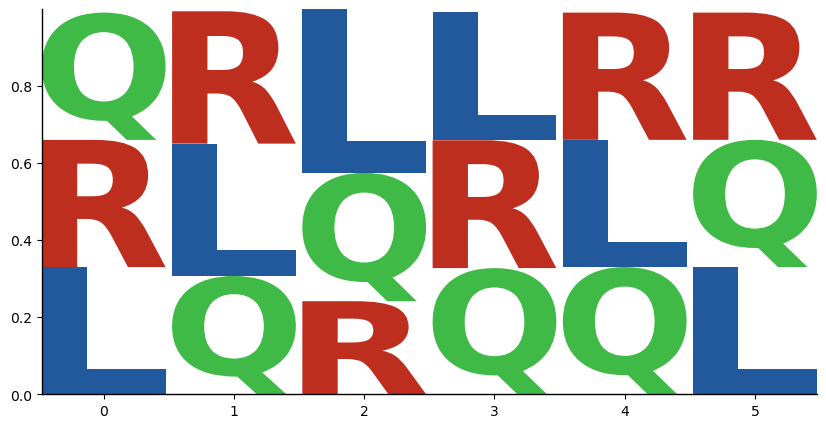

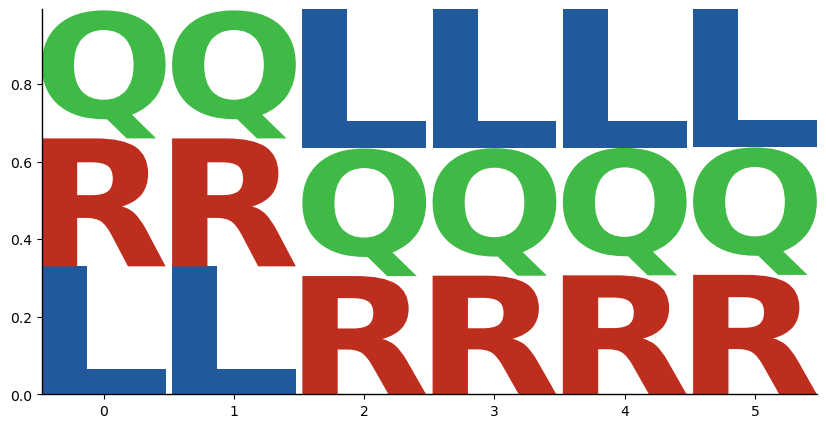

In [7]:
print(recon_data_train[0][0].shape)
# Input
plot_logos_probs(dataset_msa.prot_space, alphabets)
# Target
plot_logos_probs(ref_msa, alphabets)
# Transformation
plot_logos_probs(recon_data_train[5], alphabets)
# Reconstruction
plot_logos_probs(recon_data_train[0][0], alphabets)
